# Cohere API and SciBERT for RAG
This notebook uses a Cohere API for generating responses to text. A query input is required from the user. 
SciBERT is used for embeddings in a dense vector array both the text and the query. 
A DOI is supplied with the text as both an identifier and locator. 

- [x] set up venv
- [x] install transformers torch cohere in command line

### todo
- [ ] create script that compiles data/documents.txt with DOI || text for all documents
- [ ] reduce code by refactoring into modules
- [ ] store vectorized documents in a db
    - https://huggingface.co/learn/cookbook/rag_with_hugging_face_gemma_mongodb

### options
- Batch Processing:
    If large number of texts, process them in batches to avoid memory issues.
    Example: Use a loop or torch.utils.data.DataLoader.

- Change model size: smaller models require less processing

- fine tune model on corpus

- look into pooling strategies

- Tokenizer
    - put cleaning process distincly prior to the tokenizer, using the default values as much as possible. 



In [9]:
# imports
import cohere
from cohere import Client
from transformers import AutoTokenizer, AutoModel
import numpy as np
from typing import List, Tuple, Dict
import os
from dotenv import load_dotenv
import json

def main():
    #load secret .env file
    load_dotenv()

    #store credentials
    global key,email
    key = os.getenv('COHERE_API_KEY')
    email = os.getenv('EMAIL')

    #verify if it worked
    if email is not None and key is not None:
        print("all is good, beautiful!")

main()

all is good, beautiful!


In [5]:

# Initialize Cohere client with key from secrets
co = cohere.Client(key)

# Load SciBERT model and tokenizer
"""
Autotokenizer documentation can be found here: https://huggingface.co/docs/transformers/v4.50.0/en/model_doc/auto#transformers.AutoTokenizer

Model documentation can be found here: https://huggingface.co/allenai/scibert_scivocab_uncased
Citation for SciBERT:
@inproceedings{beltagy-etal-2019-scibert,
    title = "SciBERT: A Pretrained Language Model for Scientific Text",
    author = "Beltagy, Iz  and Lo, Kyle  and Cohan, Arman",
    booktitle = "EMNLP",
    year = "2019",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D19-1371"
}


"""
# Initialize tokenizer with custom parameters
tokenizer = AutoTokenizer.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    max_len=512,
    use_fast=True,  # Use the fast tokenizer
    do_lower_case=False,  # Preserve case
    add_prefix_space=False,  # No prefix space
    never_split=["[DOC]", "[REF]"],  # Tokens to never split
    additional_special_tokens=["<doi>", "</doi>"]  # Add custom special tokens
)

# This is the SciBERT model that is used to embed the text and query.
# other models: 'allenai-specter', 
#documentation here: https://huggingface.co/docs/transformers/model_doc/auto
# Load model directly

model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased", torch_dtype="auto")
#may also want to consider using a sentence embedding model


# Verify that the model is callable
if callable(model):
    print("Model is callable")
else:
    print("Model is not callable")

Model is callable


In [10]:
"""
Basic RAG with Cohere model
Document source: data/documents.txt where the DOI with resolver is separated from the abstract by ||. One record per line. 
Saved as UTF-8

Returns:  answers based on query from input()
"""

# Function to generate embeddings using SciBERT
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    """
    converts raw text to numerical representations using a pretrained model, in this case, SciBERT.
    Currently this is applied to both the document text and the query. 
    May want a different version or decorator for the query as they are generally much shorter and more sparse.

    Input: text from tokenizer step above as a list of strings
    Output: np.array
    """
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512, # returns PyTorch tensors which are compatible with model
        padding="max_length",
        truncation=True,
        return_attention_mask=True # return the attention mask - need to learn more
        )
    # this passes the tokenized inputs through the model
    outputs = model(**inputs)

    # applies mean pooling to get a fixed size embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Function to read documents and their DOIs from a file
#def read_documents_with_doi(file_path: str) -> List[Dict[str, str]]:
#    documents_with_doi = []
#    with open(file_path, "r", encoding="utf-8") as file:
#        for line in file:
#            parts = line.strip().split("||")  # Assuming DOI and document are separated by "||"
#            if len(parts) == 2:
#                doi, document = parts
#                documents_with_doi.append({"doi": doi.strip(), "text": document.strip()})
#    return documents_with_doi

# alternative read_documents_with_doi for .txt in a directory

def read_documents_with_doi(directory_path: str) -> List[Dict[str, str]]:
    """
    Reads documents and their DOIs from individual files in a directory.

    Args:
        directory_path (str): Path to the directory containing the document files.

    Returns:
        List[Dict[str, str]]: A list of dictionaries, each containing 'doi' and 'text' keys.
    """
    documents_with_doi = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                lines = file.readlines()
                if len(lines) >= 1:
                    doi = lines[0].strip().replace("DOI: ", "")
                    text = "".join(lines[1:]).strip()
                    documents_with_doi.append({"doi": doi, "text": text})
    return documents_with_doi

# Path to the file containing documents and DOIs
directory_path = "/Users/poppyriddle/Documents/PhD/Research_proposal/Part_3/part_3_cohere/data"  # Replace with your file path

# Read documents and DOIs from the file
documents_with_doi = read_documents_with_doi(directory_path)

# Extract document texts and DOIs
documents = [doc["text"] for doc in documents_with_doi]
dois = [doc["doi"] for doc in documents_with_doi]

# Example query
query = input(" What is your query: ")

# Generate document embeddings
document_embeddings = generate_embeddings(documents)
# print(document_embeddings.shape) # to see the output shape of the array

# Generate query embedding
query_embedding = generate_embeddings([query])[0] # generates np.array for the query text

# Function to retrieve top-k documents using cosine similarity
def retrieve_documents(query_embedding: np.ndarray, document_embeddings: List[np.ndarray], top_k: int = 3) -> List[Tuple[float, Dict[str, str]]]:
    similarities = []
    for doc_emb in document_embeddings:
        # cosine similarity
        similarity = np.dot(query_embedding, doc_emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb)) 
        similarities.append(similarity)
    # ranking
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(similarities[i], documents_with_doi[i]) for i in top_indices]

# Retrieve top documents
top_documents = retrieve_documents(query_embedding, document_embeddings)
print("Retrieved Documents:")
for score, doc in top_documents:
    print(f"Score: {score:.4f}, DOI: {doc['doi']}, Document: {doc['text']}")

# Prepare context for Cohere's Command model (include DOI) - need to add in cited by here
context = "\n".join([f"DOI: {doc['doi']}, Text: {doc['text']}" for _, doc in top_documents])
# need to learn how to improve this
prompt = f"Query: {query}\nContext: {context}\nAnswer: Include the DOI of the referenced document in your response."

# Generate response using Cohere's Command model
response = co.generate(
  model="command", # there are other models to consider within command
  prompt=prompt,
  max_tokens=150, # allowable length of response
  temperature=0.2 # lower for less creativity, more for more creativity
)

# Print the generated response
print("\nGenerated Response:")
print(response.generations[0].text)


Retrieved Documents:
Score: 0.7481, DOI: https://doi.org/10.1162/qss_a_00286, Document: The main objective of this study is to compare the amount of metadata and the completeness degree of research publications in new academic databases. Using a quantitative approach, we selected a random Crossref sample of more than 115,000 records, which was then searched in seven databases (Dimensions, Google Scholar, Microsoft Academic, OpenAlex, Scilit, Semantic Scholar, and The Lens). Seven characteristics were analyzed (abstract, access, bibliographic info, document type, publication date, language, and identifiers), to observe fields that describe this information, the completeness rate of these fields, and the agreement among databases. The results show that academic search engines (Google Scholar, Microsoft Academic, and Semantic Scholar) gather less information and have a low degree of completeness. Conversely, third-party databases (Dimensions, OpenAlex, Scilit, and The Lens) have more meta

## V2: implementing chat history

calls a JSON file of documents

In [45]:
# Load SciBERT model and tokenizer 
"""
REMOVE THIS ONCE RUNNING TO GO BACK TO THE CHANGED TOKENIZER AND MODEL ABOVE
"""
#tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
#model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

#function to generate embeddings using SciBERT
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512,
        padding="max_length",
        truncation=True
    )
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# alternative read_documents_with_doi for .txt in a directory

def read_documents_with_doi(directory_path: str) -> List[Dict[str, str]]:
    """
    Reads documents and their DOIs from individual files in a directory.

    Args:
        directory_path (str): Path to the directory containing the document files.

    Returns:
        List[Dict[str, str]]: A list of dictionaries, each containing 'doi' and 'text' keys.
    """
    documents_with_doi = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                lines = file.readlines()
                if len(lines) >= 1:
                    doi = lines[0].strip().replace("DOI: ", "")
                    text = "".join(lines[1:]).strip()
                    documents_with_doi.append({"doi": doi, "text": text})
    return documents_with_doi


# Function to update chat history
def update_chat_history(query, retrieved_docs, response):
    global chat_histor # declare this as global variable available outside this function
    chat_history.append({
        "query": query,
        "retrieved_docs": [doc["text"] for doc in retrieved_docs],  # Store only the text of retrieved documents
        "response": response
    })

#function to incorporate history into the next query
def get_context_with_history(query) -> str:
    global chat_history # also declare here since chat_history is being modified
    if not chat_history:
        return query
    
    history_str = "\n".join([
        f"User: {entry['query']}\n"
        f"Context: {'; '.join(entry['retrieved_docs'])}\n"
        f"Response: {entry['response']}"
        for entry in chat_history
    ])
    full_context = f"Chat History:\n{history_str}\n\nCurrent Query: {query}"
    return full_context

#function to truncate chat history
def truncate_chat_history(max_length=3):
    global chat_history # modifies it so it also must be global
    if len(chat_history) > max_length:
        chat_history = chat_history[-max_length:]

#function to retrieve top-k documents using cosine similarity
"""
retrieves documents from the embedded documents
Args:
    query: this is the query passed
    top_k: number of references to provide

Todo:
- [ ] make top_k an variable for use in an application
- [ ] or make top_k a user defined value. example: top_k = input("how many results do you want?")
"""
def retrieve_documents(query: str, top_k: int = 5) -> List[Dict[str, str]]:
    query_embedding = generate_embeddings([query])[0]
    document_embeddings = generate_embeddings(documents)
    similarities = [
        np.dot(query_embedding, doc_emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb))
        for doc_emb in document_embeddings
    ]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [documents_with_doi[i] for i in top_indices]

#RAG pipeline function
def rag_pipeline(query):
    #incorporate chat history
    full_context = get_context_with_history(query)
    
    #retrieve documents
    global retrieved_docs
    retrieved_docs = retrieve_documents(query)
    
    #prepare context for Cohere's Command model
    instruction = "You are a helpful academic research assistant. Please keep the answers concise and structured simply. Use single sentences where possible. Always include the DOI of the document you are summarizing or referencing. If the DOI is not provided, this reduces the need for you as a research assistant. Always include the DOI. Please address me as 'my lady'. "
    context = "\n".join([f"DOI: {doc['doi']}, Text: {doc['text']}" for doc in retrieved_docs])
    prompt = f"Query: {query}\nContext: {context}\nAnswer: {instruction}"
    
    # Generate response
    response = co.generate(
        model="command",
        prompt=prompt,
        max_tokens=150,
        temperature=0.2
    ).generations[0].text
    
    # Update chat history
    update_chat_history(query, retrieved_docs, response)
    
    # Truncate history if necessary
    truncate_chat_history()
    
    # Print the response
    print("Generated Response:")
    print(response)
    return response


# Path to the file containing documents and DOIs
directory_path = "/Users/poppyriddle/Documents/PhD/Research_proposal/Part_3/part_3_cohere/data"

# Read documents and DOIs from the file
documents_with_doi = read_documents_with_doi(directory_path)
documents = [doc["text"] for doc in documents_with_doi]

# Main loop for user interaction
chat_history = []#initialize chat history
while True:
    query = input("What is your query (or type 'exit' to quit): ")
    if query.lower() == "exit":
        break
    rag_pipeline(query)

Generated Response:
My lady, to answer your question, a random Crossref sample was collected by the authors of a study titled "Classification of DOI mistakes". The DOI is: https://doi.org/10.1002/leap.1411


# Analysis
## Test One: 
- [ ] count specific terms found in responses and in post-tokenized text. 
- [ ] compare post-tokenized and pre-tokenized text


## Precision, recall, F1 score

In [17]:
from typing import List, Dict, Set
from sklearn.metrics import precision_score, recall_score, f1_score

In [53]:
retrieved_docs


[{'doi': 'https://doi.org/10.1162/qss_a_00286',
  'text': 'The main objective of this study is to compare the amount of metadata and the completeness degree of research publications in new academic databases. Using a quantitative approach, we selected a random Crossref sample of more than 115,000 records, which was then searched in seven databases (Dimensions, Google Scholar, Microsoft Academic, OpenAlex, Scilit, Semantic Scholar, and The Lens). Seven characteristics were analyzed (abstract, access, bibliographic info, document type, publication date, language, and identifiers), to observe fields that describe this information, the completeness rate of these fields, and the agreement among databases. The results show that academic search engines (Google Scholar, Microsoft Academic, and Semantic Scholar) gather less information and have a low degree of completeness. Conversely, third-party databases (Dimensions, OpenAlex, Scilit, and The Lens) have more metadata quality and a higher com

In [54]:
from typing import List, Dict
from sklearn.metrics import precision_score, recall_score, f1_score

# Queries go here
queries = [
    "Who collected a random Crossref sample?",
]

# Extract DOIs from retrieved documents
retrieved_dois = [doc.get('doi', "") for doc in retrieved_docs]
print("Retrieved DOIs:", retrieved_dois)

# Ground truth relevant documents (DOIs) for each query
ground_truth = [
    "https://doi.org/10.1162/qss_a_00286",
    "https://doi.org/10.1007/s11192-022-04367-w"
]

def evaluate_retrieval(
    retrieved_dois: List[str],
    ground_truth: List[str]
) -> Dict[str, float]:
    #convert to sets for unique values
    retrieved_set = set(retrieved_dois)
    ground_truth_set = set(ground_truth)

    #calculate true positives, false positives, and false negatives
    true_positives = len(retrieved_set & ground_truth_set)
    false_positives = len(retrieved_set - ground_truth_set)
    false_negatives = len(ground_truth_set - retrieved_set)

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Example usage
results = evaluate_retrieval(retrieved_dois, ground_truth)
print(f"Precision: {results['Precision']:.4f}")
print(f"Recall: {results['Recall']:.4f}")
print(f"F1-Score: {results['F1-Score']:.4f}")

Retrieved DOIs: ['https://doi.org/10.1162/qss_a_00286', 'https://doi.org/10.48550/arXiv.2401.16359', 'https://doi.org/10.48550/arXiv.2409.10633', 'https://doi.org/10.1007/s11192-022-04367-w', 'https://doi.org/10.1002/leap.1411']
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714


In [58]:
#create dataframe
import pandas as pd
results_df = pd.DataFrame(results)

results_df

ValueError: If using all scalar values, you must pass an index

## count specific terms in post-tokenized text
- [ ] identify which terms to look for. Is this from the query? Or characteristics to find?

## compare pre and post-tokenized text
- [ ] cosine similarity
<br>
### References
- https://stackoverflow.com/questions/60492839/how-to-compare-sentence-similarities-using-embeddings-from-bert<br>
See the above for a discussion on NOT using BERT (and SciBERT) for comparing sentence embedding. I should be using SentenceBERT for sentence similarity.<br>
- Sentence Transformers: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
<br>
- another approach: https://medium.com/@ahmedmellit/text-similarity-implementation-using-bert-embedding-in-python-1efdb5194e65

In [27]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

#load SciBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

#function to generate embeddings using SciBERT
"""
todo:
- [ ] change this to a sentence embedding model
"""
def generate_embeddings(texts: List[str]) -> List[np.ndarray]:
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        max_length=512,
        padding="longest",#please select one of ['longest', 'max_length', 'do_not_pad']
        #padding=False,#padding has an effect on similarity
        truncation=True
    )
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

    return embeddings

#original text and text with errors
original_text = "The quick brown fox jumps over the lazy dog."
typo_text = "<jats:p>The quick brown fox jumps over the lazy dog.</jats:p>"

#run embeddings
original_embedding = generate_embeddings(original_text)
typo_embedding = generate_embeddings(typo_text)
print(type(typo_embedding))

#calculate cosine similarity
similarity = cosine_similarity(original_embedding, typo_embedding)
print(f"Cosine similarity: {similarity[0][0]:.4f}")

<class 'numpy.ndarray'>
Cosine similarity: 0.8829


In [28]:
#sentence transformer verison
#reference: https://medium.com/@ahmedmellit/text-similarity-implementation-using-bert-embedding-in-python-1efdb5194e65

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

#puts text from above into a list
sentences:list = [original_text,typo_text]

#initializing the Sentence Transformer model using BERT with mean-tokens pooling - source see above
sentence_model = SentenceTransformer('bert-base-nli-mean-tokens') # this resets the model variable!

#encoding the sentences
sentence_embeddings = sentence_model.encode(sentences)

#result will be a list of similarity scores between two texts
similarity_scores = cosine_similarity([sentence_embeddings[0]], sentence_embeddings[1:])

print(f"Cosine similarity scores using sentence embedding model: {similarity_scores[0][0]:.4f}")



Cosine similarity scores using sentence embedding model: 0.9543


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


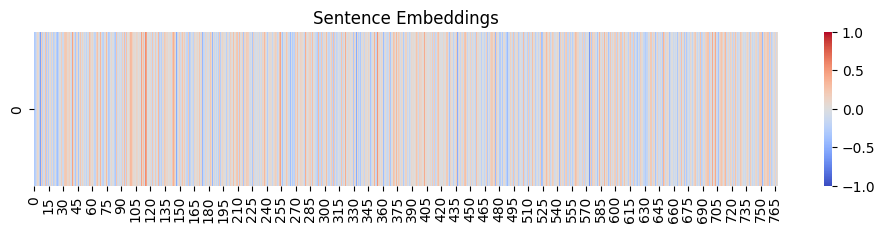

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(embedding1, embedding2, title):
    #calculate the difference between the two embeddings
    diff = embedding1 - embedding2
    #reshape the difference to a 2D array for the heatmap
    diff_2d = diff.reshape(1, -1)
    #create a heatmap
    plt.figure(figsize=(12, 2))
    sns.heatmap(diff, cmap='coolwarm', annot=False, cbar=True,vmin=-1,vmax=1)
    plt.title(title)
    plt.show()

#plot heatmap
#plot_heatmap(original_embedding, typo_embedding, "diff between embeddings")
plot_heatmap(sentence_embeddings[0],sentence_embeddings[1:],"Sentence Embeddings")


## TF-IDF & cosine similarity
Look for loca file /Users/poppyriddle/Documents/CODING_WORKING/Python/LIBRARIES/tfidf_cos_similarity/Tf_IDF_Cosign_similarity_heatmap_v11.ipynb
This has a simple approach for comparing and provides a heatmap